In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


# 1. 내 사진으로 인물 사진 만들기

(960, 1280, 3)


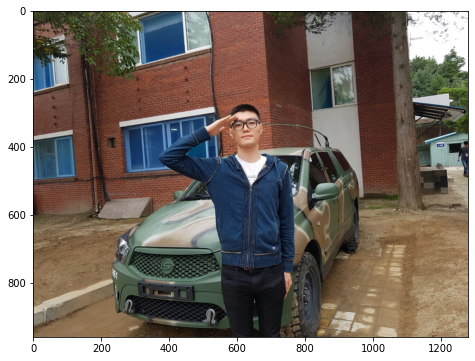

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ff984518520>)

### 그 다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### 모델에 이미지를 입력

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

### PASCAL VOC 데이터의 라벨 종류

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 출력값 살펴보기

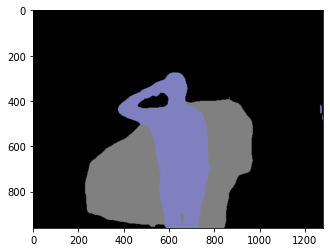

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

### 15번째 색상 맞추기

In [11]:
colormap[15]

array([192, 128, 128])

### colormap은 RGB 순서 그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 함

In [12]:
seg_color = (128,128,192)

(960, 1280)


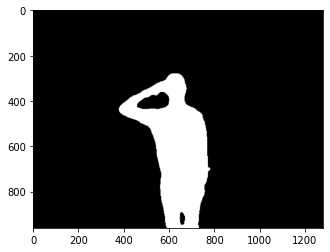

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

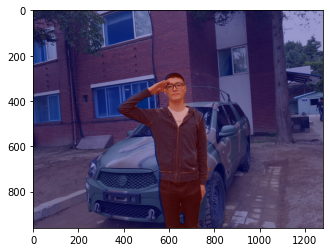

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 만들기

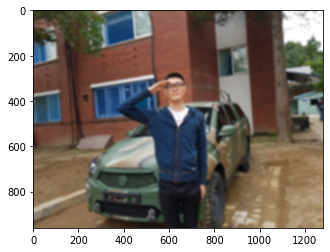

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

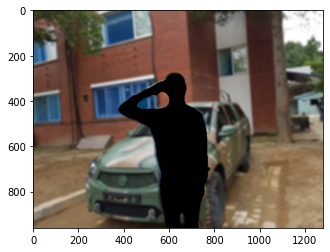

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐리게 만든 배경과 내 인물 사진을 합친다

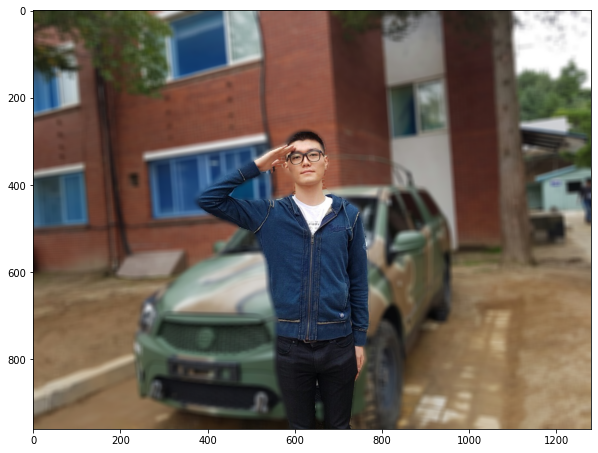

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.

# 2. 배경 바꾸기

(1280, 1280, 3)


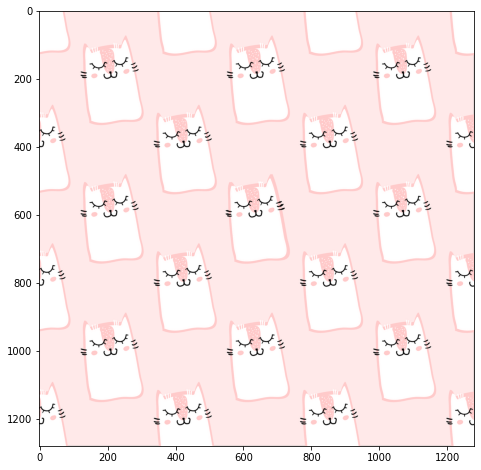

In [18]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cute.png'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
res = cv2.resize(img_orig3, (1280,960))

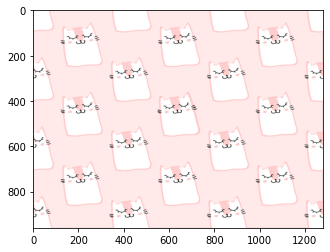

In [20]:
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

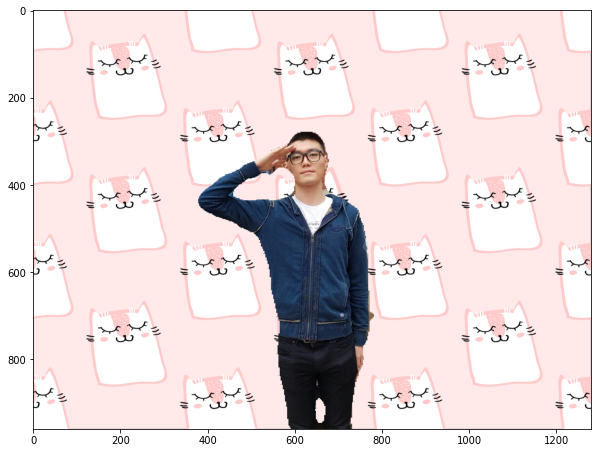

In [21]:
img_concat = np.where(img_mask_color==255, img_orig, res)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 강아지 사진 인물사진 만들기

(1280, 563, 3)


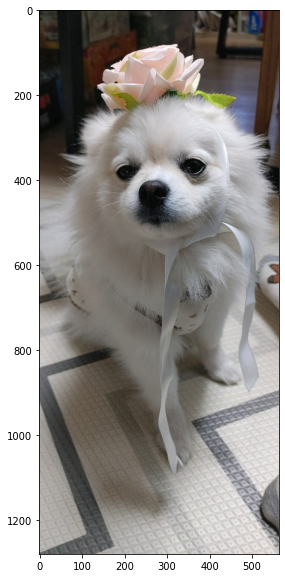

In [22]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png' 
img_orig2 = cv2.imread(img_path2) 
print(img_orig2.shape)
plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

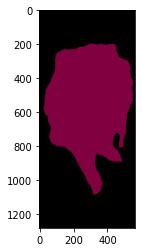

In [24]:
plt.imshow(output2)
plt.show()

In [25]:
print(segvalues2)

{'class_ids': array([ 0, 12]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}


In [26]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [27]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [28]:
colormap[12]

array([ 64,   0, 128])

In [29]:
seg_color2 = (128, 0, 64)

(1280, 563)


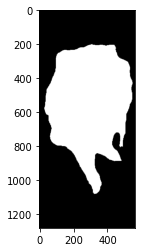

In [30]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map2 = np.all(output2==seg_color2, axis=-1)
print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

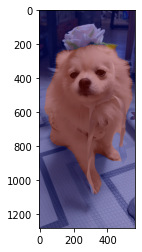

In [31]:
img_show = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 만들기

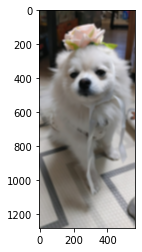

In [32]:
img_orig_blur = cv2.blur(img_orig2, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

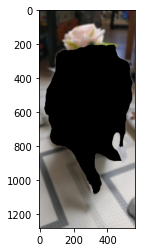

In [33]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

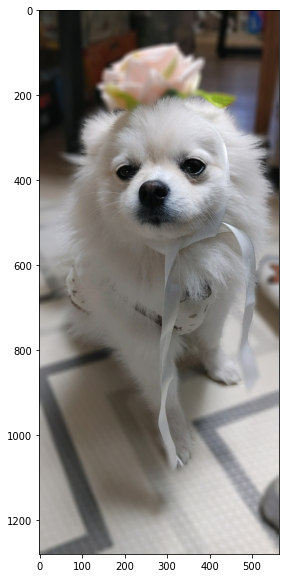

In [38]:
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.figure(figsize=(8,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 문제점

인물 사진에서 나와 배경 사이의 윤곽선이 흐려져서 이미지가 부정확하게 나오는 것(배경을 블러처리하는 과정에서 인물과 배경사이에도 똑같이 blur가 적용됨)을 발견했고, 배경을 교체한 사진에서 사람과 배경을 따로 분리 했지만 경례 사진 손 뒤에 배경이 인물 사진에 약간 포함 되어있는 문제점을 발견했다. 

# 5. 해결방안

파사계 심도는 사진에서 초점이 맞은 것으로 인식되는 범위입니다. 렌즈에서 초점이 맞는 거리는 딱 한 부분입니다. 이 부분을 초점면이라고 부르며 초점면을 중심으로 서서히 흐려지는 현상이 나타납니다. 나의 사진을 보면 배경이 나와 가까이 있고 사진을 멀리서 찍었다는 것을 확인할 수 있다. 즉 나와의 배경 사이의 거리를 늘린다면 아웃포커싱이 잘 돼서 배경과 인물 간의 구분을 더 잘할 수 있을 것 같다. 카메라에 좀 더 가까이가면 해결될 것이다.